In [1]:
from IPython.display import Video
from IPython.display import HTML
import jax
import jax.numpy as jnp
import scipy
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - Intro

### David Picard 
### École des Ponts ParisTech
### david.picard@enpc.fr

# Resources

Books:

[Trevor Hastie, Robert Tibshirani, Jerome Friedman, The Elements of Statistical Learning: Data Mining, Inference, and Prediction.](https://web.stanford.edu/~hastie/ElemStatLearn/)

[Shai Shalev-Shwartz, Shai Ben-David, Understanding Machine Learning: From Theory to Algorithms](https://www.cs.huji.ac.il/~shais/UnderstandingMachineLearning/)

[Kevin P. Murphy, Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html)

In French: [Chloé-Agathe Azencott, Introduction au Machine Learning](https://cazencott.info/index.php/pages/Introduction-au-Machine-Learning)

Other lectures at ENPC:
- Deep Learning, Stat en grande dimension

This lecture uses [JAX](https://jax.readthedocs.io) because I want to keep it low level and look at how the algorithms work under the hood. In practice there are many high level libraries. Do not reinvent the wheel, but beware that some sell square wheels...

# Setup

- Coupled random variables $X, y$ with unknown pdf $P(X, y)$, $P(X)$ or $P(y)$
- $X \in \mathcal{X}$ input domain
- $y \in \mathcal{Y}$ output domain

We want to find a function $f$ that approximates $y$ from $X$

## Expected Error

- To measure to quality of the approximation: loss function $l(f(x), y)$
  - example: $l(f(X), y) = 1$ if $f(X) \neq y, 0$ else
- Find $f$ that minimizes the average error

$$\mathbb{E}_{\sim X,y}[l(f(X), y)]$$



## Two problems
1. $P(X,y)$ is unknown
  - Complex phenomenon, no explicit model
2. Finding a minimizer may be difficult
  - example: $l(f(X), y) = 1$ if $f(X) \neq y, 0$ else $\Rightarrow$ SAT problem, NP-hard

# Empirical risk minimization
Solving problem #1, $P(X,y)$ is unknown:


If $P$ was known, we would use

$$f(x) = \arg\max_y P(y|x)$$

which is our best guess and would lead to the following error

$$P_e = \int \left(1 - \max_y P(y|x)\right)p(x)dx$$

(Bayes error)

This is the lowest achievable error rate.

- If the process is deterministic, then $\max_yP(y|x)=1$ and perfect prediction can be achieved.

- If the process is intrinsically random (*e.g.*, throw 2 dice, $x$ is the first dice, $y$ is the sum of the dice), then there is some irreducible error.

Estimate the error instead:

- Training set of examples $\mathcal{A} = \{(X_i, y_i)\}_{i\leq n}$ sampled from $P(X,y)$

- Approximate the expected error by the empirical risk

$$E(f) = \frac{1}{n} \sum_i l(f(X_i), y_i)$$

- Find $f$ that minimizes $E(f)$

$$ f^\star = \arg\min_f E(f)$$

## A Bad Example
Consider the function
$$ f(X) = \begin{cases}y_i\text{ if }\exists X_i \in \mathcal{A}\text{ such that }X_i = X \\ 0\text{ else}\end{cases}$$

Obviously
$$E(f) = 0$$

However, $f$ is pretty useless at predicting anything outside of $\mathcal{A}$

## A not-as-bad example

Points inside a random circle

In [2]:
def gt(x):
    x1 = x[:,0] > 0.
    x2 = x[:,0] < 0.8
    y1 = x[:,1] > 0.2
    y2 = x[:,1] < 0.8
    return 1*(x1 * x2 * y1 * y2)

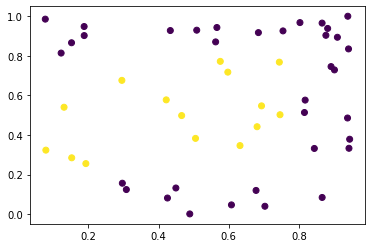

In [3]:
key = jax.random.PRNGKey(0)
key, skey = jax.random.split(key)
X = jax.random.uniform(skey, (50, 2))
y = gt(X)

plt.scatter(X[:,0], X[:,1], c=y)

In [4]:
class CirclePredictor:
    def __init__(self, key):
        key, skey = jax.random.split(key)
        self.c = jax.random.uniform(key, (2,))
        self.r = jax.random.uniform(skey)
    def __call__(self, X):
        return jnp.sign(1*((X[:,0] - self.c[0])**2 + (X[:,1] - self.c[1])**2 < self.r**2))

def loss(y_pred, y_true):
    return (1-(y_pred==y_true)).mean()

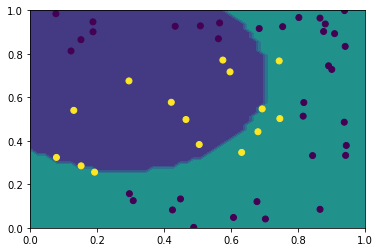

In [5]:
key, skey = jax.random.split(key)
pred = CirclePredictor(skey)

t = 50; tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = pred(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels); plt.scatter(X[:,0], X[:,1], c=y)

## (Randomly) Searching for a good $f$

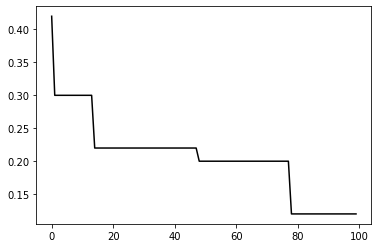

In [6]:
fig = plt.figure()
camera = Camera(fig)
key = jax.random.PRNGKey(7)
l_min = 20; f_best = None
le = []
for i in range(100):
    key, skey = jax.random.split(key)
    f = CirclePredictor(skey)
    l = loss(f(X), y)
    if l < l_min:
        l_min = l; f_best = f
    le.append(l_min)
    plt.plot(le, '-k'); camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())

## Are we lucky

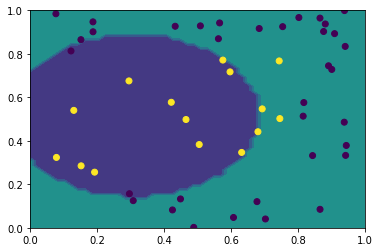

In [7]:
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = f_best(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y)

# Generalization

- We know $f$ is good on $\mathcal{A}$ (at least better than other)
- We don't know if it's good on other samples


The difference between the expected risk and the empirical risk is know as the *generalization gap*

- A function that performs poorly on unseen data compared to training data is *overfitting*

How do we know if $f$ is overfitting?
- Measuring the error on $\mathcal{A}$ is not informative $\Rightarrow$ Split the examples into training and evaluation sets


## Let's try

In [8]:
key = jax.random.PRNGKey(6)
Xt = jax.random.uniform(key, (50, 2))
yt = gt(Xt)

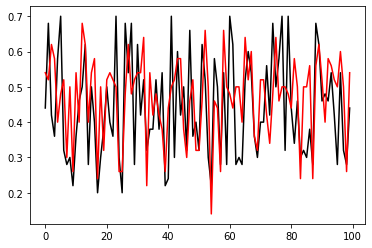

In [9]:
fig = plt.figure()
camera = Camera(fig)
key = jax.random.PRNGKey(1)
l_min = 20; f_best = None
le = []
lt = []
for i in range(100):
    key, skey = jax.random.split(key)
    f = CirclePredictor(skey)
    l = loss(f(X), y)
    if l < l_min:
        l_min = l; f_best = f
    le.append(l)
    lt.append(loss(f(Xt), yt))
    plt.plot(le, '-k'); plt.plot(lt, '-r'); camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())

Both errors are correlated (the contrary would be very worrying), but some extreme values may be very different. We are at the risk of selecting an $f$ because we were lucky.

# k-NN: A Better learning machine

$k$ nearest neighbor: prediction is a vote among $k$ nearest elements of the training set

Example $1-NN$:

$$f(x) = y_i \text{  s.t.  }  i = \arg\min_{x_j \in \mathcal{A}} \| x - x_j \|^2$$

- Memorizes the entire training set
- Does 0 empirical error on $\mathcal{A}$

In [10]:
class FirstNearestNeighbor:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __call__(self, x):
        dist = ((self.X[None,:,:] - x[:,None,:])**2).sum(axis=2) # broadcast to B x n x dim
        index = jnp.argmin(dist, axis=1)
        return y[index]    

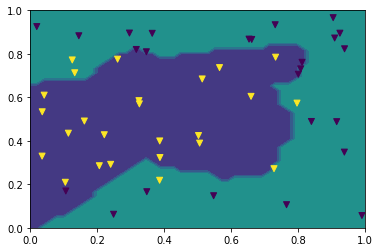

In [11]:
nn = FirstNearestNeighbor(X, y)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
#plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

## What is the effect of k?

In [12]:
class KNearestNeighbor:
    def __init__(self, X, y, k=1):
        self.X = X
        self.y = y
        self.k = k
    def __call__(self, x):
        dist = ((self.X[None,:,:] - x[:,None,:])**2).sum(axis=2) # broadcast to B x n x dim
        indices = jnp.argsort(dist, axis=1)
        yp = 1*((self.y[indices[:,0:self.k]]).sum(axis=1) > self.k//2)
        return yp

(<matplotlib.collections.PathCollection at 0x7f09e1ff8a10>,
 <matplotlib.collections.PathCollection at 0x7f09e1ff8b50>)

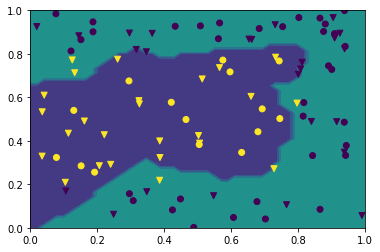

In [13]:
nn = KNearestNeighbor(X, y, k=1)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

(<matplotlib.collections.PathCollection at 0x7f09e1ff8f90>,
 <matplotlib.collections.PathCollection at 0x7f0988784a10>)

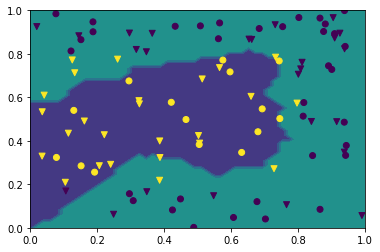

In [14]:
nn = KNearestNeighbor(X, y, k=2)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

(<matplotlib.collections.PathCollection at 0x7f09e1ff4d90>,
 <matplotlib.collections.PathCollection at 0x7f098878a350>)

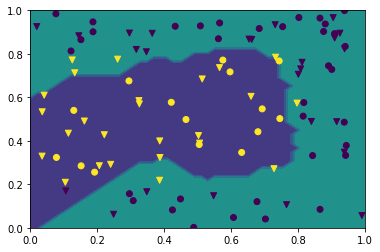

In [15]:
nn = KNearestNeighbor(X, y, k=3)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

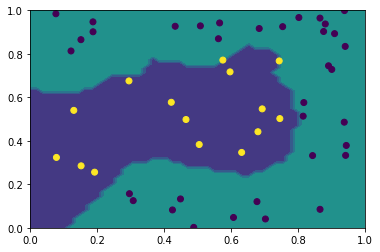

In [16]:
nn = KNearestNeighbor(X, y, k=5)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y)#, plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

## Model selection
How do we select k?
- They all do 0 error on $\mathcal{A}$

- We can split $\mathcal{A}$ in 2:

  - One for training each k-NN: *training* set
  
  - One for evaluating each k-NN: *validation* set
  
Since the validation set is used to select a model, it cannot be used to give us an idea of the expected risk



Standard 3-split procedure: *train, validation, test*

- Train on *train*

- Perform model selection on *validation*

- Evaluate on *test*


In [17]:
key = jax.random.PRNGKey(33)
Xv = jax.random.uniform(key, (50, 2))
yv = gt(Xt)

([<matplotlib.lines.Line2D at 0x7f09a0454f50>],
 [<matplotlib.lines.Line2D at 0x7f09e1829a50>])

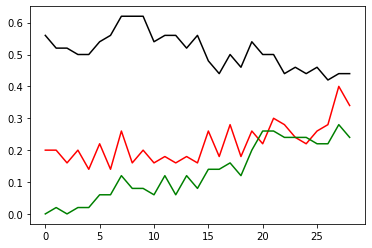

In [18]:
lv = []; lt = []; lr = []
for k in range(1,30):
    nn = KNearestNeighbor(X, y, k)
    lv.append(loss(nn(Xv), yv))
    lt.append(loss(nn(Xt), yt))
    lr.append(loss(nn(X), y))
plt.plot(lv, '-k'), plt.plot(lt, '-r'), plt.plot(lr, '-g')

(<matplotlib.collections.PathCollection at 0x7f09a0021850>,
 <matplotlib.collections.PathCollection at 0x7f09e17e9550>)

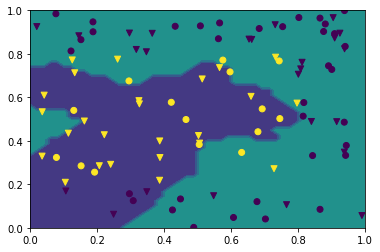

In [19]:
nn = KNearestNeighbor(X, y, k=17)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

# Statistical fluke?

Knowing that $f$ does $\epsilon$ expected error, what is the probability that $f$ has an empirical error of $\eta$ or less on a dataset of size $n$?

- Probability that $f$ does *exactly* $m$ error over $n$ samples
$$ {n \choose m} \epsilon^m (1-\epsilon)^{n-m} $$

- Probability that $f$ does $m$ or less error over $n$ samples
$$ \sum_{k=1}^m {n \choose k}\epsilon^k(1-\epsilon)^{n-k}$$

For $\eta$ observe error rate
$$ \sum_{k=1}^{\lfloor \eta n \rfloor}{n \choose k} \epsilon^k(1-\epsilon)^{n-k}$$

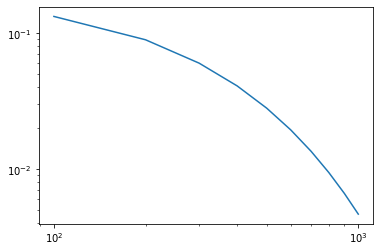

In [20]:
def Pn_of_eta_given_eps(n, eta, eps):
    p = 0
    for k in range(int(eta*n)):
        p += scipy.special.comb(n, k) * eps**k * (1-eps)**(n-k)
    return p
x = range(100, 1100, 100)
p = [Pn_of_eta_given_eps(i, 0.01, 0.02) for i in x]
plt.loglog(x, p)

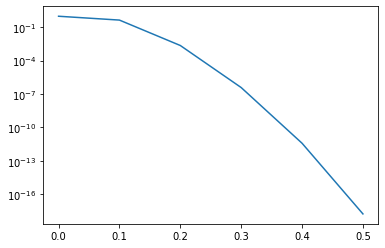

In [21]:
x = 0.1*jnp.arange(0, 6, 1)
p = [Pn_of_eta_given_eps(100, 0.1, i) for i in x]
plt.semilogy(x, p)

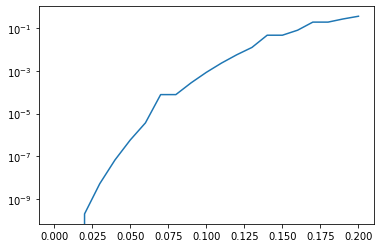

In [22]:
x = 0.01*jnp.arange(0, 21, 1)
p = [Pn_of_eta_given_eps(100, i, 0.2) for i in x]
plt.semilogy(x, p)

## Cross-validation

Split the data into several training-validation sets and average the error

- Random split: perform $r$ random splits of $x\%$ training $(1-x)\%$ validation (typically 80/20)

- K-fold: split in $k$ subsets and perform $k$ permutations $k-1$ sets for training, 1 set for validation

Select model that has lowest average validation error and evaluate on test

- Variance gives an idea of the relevance of the selection process

In [23]:
key = jax.random.PRNGKey(4) # chosen by a fair dice roll
X = jax.random.uniform(key, (100, 2))
y = gt(X)

In [24]:
def randomSplit(key, X, y, train_part=0.8):
    n = X.shape[0]
    n_train = int(train_part*n); n_test = n - n_train
    p = jax.random.permutation(key, n)
    X_train = X[p[0:n_train], :]; y_train = y[p[0:n_train]]
    X_val = X[p[n_train:],:] ; y_val = y[p[n_train:]]
    return X_train, y_train, X_val, y_val

<ErrorbarContainer object of 3 artists>

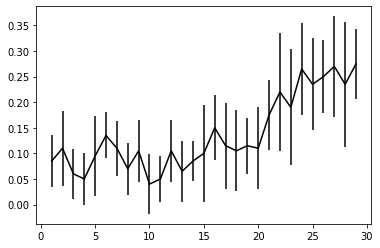

In [25]:
key = jax.random.PRNGKey(32)
l = []
for k in range(1, 30):
    lk = []
    for s in range(10):
        key, skey = jax.random.split(key)
        X_train, y_train, X_val, y_val = randomSplit(skey, X, y)
        nn = KNearestNeighbor(X_train, y_train, k=k)
        lk.append(loss(nn(X_val), y_val))
    l.append(lk)
l = jnp.asarray(l)
plt.errorbar(range(1,30), l.mean(axis=1), l.std(axis=1), fmt='-k')

## Full training
Once hyperparameters are selected, train on full training set, eval on test

(<matplotlib.collections.PathCollection at 0x7f09e0fca9d0>,
 <matplotlib.collections.PathCollection at 0x7f09e13e8e50>)

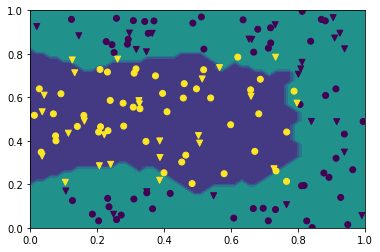

In [26]:
nn = KNearestNeighbor(X, y, k=4)
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = nn(xx).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

## Conclusion on validation in ERM
- Low training error does not imply generalization (*e.g.*, $k$-NN)
- A single run training/validation can just be lucky
- Model selection using cross-validation
- Final performance evaluation on a test set

# Finding $f$ is hard
Solving problem #2, finding a good $f$ is hard:

- 0-1 loss is difficult to optimize, alternatives?

## Regression
- $\mathcal{Y}$ is continuous
$$MSE: (y - f(X))^2, \quad MAE: |y - f(x)|$$
- Vector case: any norm of $y - f(X)$

## Classification
- $\mathcal{Y}$ is categorical $\rightarrow$ continuous relaxation, then decision with $\text{sign}(f(X))$
- Simple binary case: $\mathcal{Y} = \{-1 ; 1\}$
  - hinge loss: $\max(0, 1 - yf(X))$
  - log loss: $\log(1 + e^{-yf(X)})$
  - exp loss: $e^{-yf(X)}$

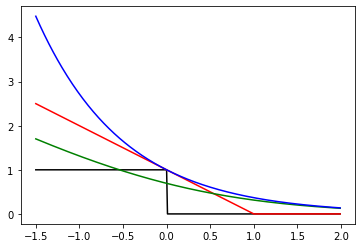

In [27]:
t = jnp.arange(-1.5, 2, 0.01)
plt.plot(t, 1-(jnp.sign(t)==1), '-k')
plt.plot(t, jnp.maximum(0, 1 - t), '-r')
plt.plot(t, jnp.log(1+jnp.exp(-t)), '-g')
plt.plot(t, jnp.exp(-t), '-b')

## Turning ERM into an optimization problem
Ellipse classifier with parameter $c_1, c_2, a, b$:
$$ f(X) = 1 - (a(X_1 - c_1)^2 +b(X_2 - c_2)^2)$$
In matrix form
$$f(X) = 1 - (X-C)^TA(X-C)$$

Using MSE
$$\min_{A, C} \sum_x (y - 1 + (x-C)^TA(x-C))^2$$

- Use optimization formulation to get closed form solution (*e.g.*, KKT)
- Use optimization techniques to get approximate solution (*e.g.*, interior points, cutting planes)
- Use gradient descent (it always gets you a better solution than random)

In [28]:
def mse(y_hat, y):
    return ((y-y_hat)**2).mean()

def circle(x, a, c):
    xc = x - c[None, :] # broadcast to n x 2
    return 1 - (a*xc**2).sum(1) # sum on axis=1

def loss(a, c, x, y):
    y_hat = circle(x, a, c)
    return mse(y_hat, y)

@jax.jit
def update(a, c, x, y):
    da, dc = jax.grad(loss, argnums=(0,1))(a, c, x, y)
    return a - 0.1 * da, c - 0.1 * dc

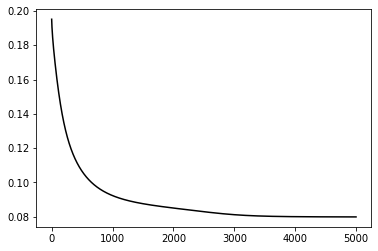

In [29]:
key = jax.random.PRNGKey(32)
key, skey = jax.random.split(key)
c = jax.random.uniform(key, (2,))
a = jnp.ones(2)
l = []
for t in range(5000):
    a, c = update(a, c, X, y)
    l.append(loss(a, c, X, y))
plt.plot(l, '-k')
    

(<matplotlib.collections.PathCollection at 0x7f09e13b4150>,
 <matplotlib.collections.PathCollection at 0x7f09e0cfd310>)

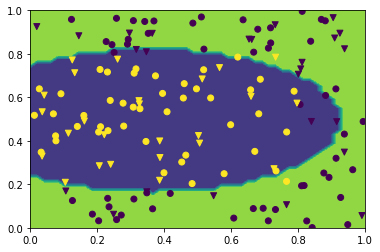

In [30]:
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = jnp.sign(circle(xx, a, c)-0.5).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

Rectangle $\rightarrow$ switch from $\ell_2$ to $\ell_\infty$ norm

$$ f(X) = 1 - \max(a(X_1 - c_1)^2, b(X_2 - c_2)^2)$$

In [31]:
def square(x, a, c):
    xc = x - c[None, :] # broadcast to n x 2
    return 1 - (a*xc**2).max(1) # inf norm

def loss(a, c, x, y):
    y_hat = square(x, a, c)
    return mse(y_hat, y)

@jax.jit
def update(a, c, x, y):
    da, dc = jax.grad(loss, argnums=(0,1))(a, c, x, y)
    return a - 0.1 * da, c - 0.1 * dc

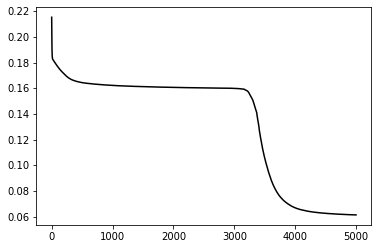

In [32]:
key = jax.random.PRNGKey(32)
key, skey = jax.random.split(key)
c = jax.random.uniform(key, (2,))
a = jnp.ones(2)
l = []
for t in range(5000):
    a, c = update(a, c, X, y)
    l.append(loss(a, c, X, y))
plt.plot(l, '-k')

(<matplotlib.collections.PathCollection at 0x7f09e136de50>,
 <matplotlib.collections.PathCollection at 0x7f09e136d350>)

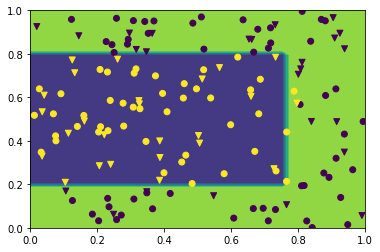

In [33]:
t = 50
tx = jnp.linspace(0, 1, t); ty = jnp.linspace(0, 1, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = jnp.sign(square(xx, a, c)-0.5).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels)
plt.scatter(X[:,0], X[:,1], c=y), plt.scatter(Xt[:,0], Xt[:,1], marker='v', c=yt)

# Exercise

- Perform cross validation on the square classifier to set the number of optimization steps
- Plot train and val losses over time with errorbars

In [34]:
def RandomSplitCV(key, X, y, cls_func, max_steps=10000):
    # get a random 80% split of X,y
    # optimize a,c using cls_func for max_steps
    # keep track of training loss and validation loss
    return l_train, l_val

In [ ]:
# perform 10 random split CV
key = jax.random.PRNGKey(67)
# l_train = jax.random.uniform(key, (10000, 10)); l_val = 0.2*l_train

# plot train and val loss
x = jnp.arange(10000)
l_mean = l_train.mean(axis=1); l_std = l_train.std(1)
plt.plot(x, l_mean, '-b'); plt.fill_between(x, l_mean, l_mean-l_std, l_mean+l_std, color='b', alpha=0.5)
l_mean = l_val.mean(axis=1); l_std = l_val.std(1)
plt.plot(x, l_mean, '-r'); plt.fill_between(x, l_mean, l_mean-l_std, l_mean+l_std, color='r', alpha=0.5)

# Conclusion on ML and optimization
- Optimizing the 0-1 loss is really hard
- Regression is easy to set (continuous target, continuous $f$, standard optimization problem)
- Classification: relax to continuous $f$, find proxy loss (*e.g.*, hinge, logistic)

- Any classification problem can be cast as a regression by arbitrarily mapping $\mathcal{Y}$ to $\mathbb{R}$

- Regression is harder to train than classification (harder to generalize)
- Any regression problem can be transformed into a classification problem by quantizing $\mathcal{Y}$ (but you lose the topology of $\mathcal{Y}$)

## ML taxonomy

 - Supervised vs Unsupervised
 
   - Supervised: $y$ is known, effective, difficult to have data
   - Unsupervised: $y$ is unknown, difficult problem, easy to obtain data
   - Semi-supervised: mix of both
   - Reinforcement learning: supervised but only after $k$ decision steps
   

 - Online vs Batch:
 
   - Batch: train once on all data
   - Online: train on stream of data, then freeze the model
   - Continuous learning: train on steam, never freeze the model
   

- Passive vs Active:
    - Passive: all training data are i.i.d.
    - Active: training data obtained via a selection process to be more efficient

- Shallow vs Deep
  - Shallow learning: handcrafted/engineered features + ML based decision
  - Deep learning: train both feature extractor and decision

# Lecture 1's take home
- ERM principle
- *train/val/test* mantra, cross-validation
- ML is optimizing parameters to fit data
- Taxonomy: supervised/unsupervised, classification/regression
- Our first learning algorithm: $k$-NN!